# Generates Figs S3 and S5 (predictions for other datasets)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy import stats, optimize

import os
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from quad_model import *
from tensorflow.keras.models import Model, load_model
from  tqdm import tqdm

import mukund_utils as utils

import force_plot

random.seed(100)
np.random.seed(100)

plt.style.use('clean.mplstyle')

188/188 [==============================] - 14s 74ms/step


# Load Baeza et al. data

FAS exon 6, 63nt. WT seq:

GATCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG

Total of 3072 mutations in their supp table. Some of the exons had high standard deviation across their replicates, so we filtered to only take those with s.d. < 0.1, which brings the number of exons down to 794. 
Their assay includes all subsets of about 12 mutations; it is not full mutagenesis. 

In [2]:
baeza_et_al_data = pd.read_excel("other_datasets/baeza_et_al_untreated_only.xls")
baeza_et_al_data = baeza_et_al_data[baeza_et_al_data["PSI.Standard.Deviation"] < 0.1] # remove highly noisy exons
baeza_et_al_data["flanked_sequence"] = baeza_et_al_data.apply(
    lambda x: "CCTACAG"+x.Sequence+"GTAAGTT", axis=1)
baeza_et_al_data.rename({"Mean.PSI":"PSI"}, axis=1, inplace=True)
baeza_et_al_data.PSI = np.minimum(baeza_et_al_data.PSI,1)
baeza_et_al_data['gene'] = "FAS"

In [3]:
all_assay_df = baeza_et_al_data[["gene", "flanked_sequence", "PSI"]]

# Load Ke et al. data

Ke et al., WT1 exon 5, 51nt, WT seq: 

AGTTGCTGCTGGGAGCTCCAGCTCAGTGAAATGGACAGAAGGGCAGAGCAA

To compute secondary structure, Ke et al. take 23nt of upstream and 16nt of down-
stream sequence. The stem loop is mainly around nt 8-22 in the exon (5+5loop+5). 
Their dataset consists of 556 exons for each of 10 different base exons (each containing a different hexamer in positions 5-10; see their Table 1). 
Their assay is unable to directly measure PSI (since they have no barcode on the constructs, they can only sequence the exon inclusion products). Instead, PSI needs to be inferred from what they call EI, using a formula they provide in their paper.

In [4]:
ke_et_al_data = pd.read_excel("other_datasets/ke_et_al_Supplemental_Table_S2_no_empty_lines.xls")
ke_et_al_data["PSI"] = np.minimum(1,0.19*ke_et_al_data.EI + 0.02)
ke_et_al_data["flanked_sequence"] = ke_et_al_data.apply(lambda x: x.seq[23-7:-(16-7)], axis=1)
ke_et_al_data['gene'] = "WT1" # + ke_et_al_data.Hexmut  # by including the Hexmut we can split it into smaller sublibraries; but it makes more sense to use their entire dataset

In [5]:
all_assay_df = pd.concat([ all_assay_df, ke_et_al_data[["gene", "flanked_sequence", "PSI"]] ])

# Load Rosenberg et al. data (SMN1, SMN2, CFTR, BRCA2)

Four genes are in the same table. SMN1 and SMN2 are marked as one (SMN1/SMN2) so need to distinguish them based on ther reference PSI (low for SMN2, high for SMN1)

In [6]:
rosenberg_et_al_data = pd.read_excel("other_datasets/rosenberg_et_al_supplementary_no_comments.xls")

In [7]:
# Gene name, name in table, WT seq, upstream 7nt, downstream 7nt, min PSI, max PSI (the latter two used to distinguish SMN1 from SMN2)
# CFTR exon 13
# BRCA2 exon 7
# SMN1/2 exon "7"
all_genes_in_rosenberg = [
    ["SMN1", "SMN1/2", "GGTTTCAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTCCTTAAATTAAGGA", "CTTACAG", "GTAAGTC", 0.5, 1],
    ["SMN2", "SMN1/2","GGTTTTAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTCCTTAAATTAAGGA", "CTTACAG", "GTAAGTC", 0, 0.5],
    ["CFTR", "CFTR", "AGCAGTATACAAAGATGCTGATTTGTATTTATTAGACTCTCCTTTTGGATACCTAGATGTTTTAACAGAAAAAGAAATATTTGAAAG", "TTTTTAG", "GTATGTT", 0, 1],
    ["BRCA2", "BRCA2", "GGTCGTCAGACACCAAAACATATTTCTGAAAGTCTAGGAGCTGAGGTGGATCCTGATATGTCTTGGTCAAGTTCTTTAGCTACACCACCCACCCTTAGTTCTACTGTGCTCATAG", "CTCCCAG", "GTAATAA", 0, 1]
]

In [8]:
def get_sequence(gene_info, pos, seq):
    wt_seq = gene_info[2]
    return (wt_seq[:pos-1] + 
            seq[:min(len(seq),len(wt_seq)-pos+1)] + 
            wt_seq[min(pos+len(seq)-1, len(wt_seq)):]
           )

def get_sequence_for_row(gene_info, row):
    assert(get_sequence(gene_info, row.POS, row.REF) == gene_info[2])
    return(get_sequence(gene_info, row.POS, row.ALT))

def get_df_for_gene(gene_info):
    df = rosenberg_et_al_data
    df = df[~df.ALT.isna()] # remove rows with "NA" as the ALT; those are deletions, which we don't handle yet; there are very few anyway
    df = df[df.Gene == gene_info[1]]
    df = df[df.REF_PSI >= gene_info[5]]  # for SMN1/SMN2, use REF_PSI to distinguish
    df = df[df.REF_PSI <= gene_info[6]]  
    df = df[df.apply(lambda x: len(x.REF) == len(x.ALT), axis=1)] # ignore indels
    df = df[df.apply(lambda x : gene_info[2][:3] == get_sequence_for_row(gene_info,x)[:3], axis=1)] # first and last 3nt are the same (same filtering done in the Rosenberg notebook "genomic_predictions - Copy")
    df = df[df.apply(lambda x : gene_info[2][-3:] == get_sequence_for_row(gene_info, x)[-3:], axis=1)]
    df["flanked_sequence"] = df.apply(lambda x: gene_info[3]+get_sequence_for_row(gene_info, x)+gene_info[4], axis=1)
    df.rename({"ALT_PSI":"PSI"}, axis=1, inplace=True)
    df["gene"] = gene_info[0]
    return df[["gene", "flanked_sequence", "PSI"]]

In [9]:
for gene_info in all_genes_in_rosenberg:
    all_assay_df = pd.concat([ all_assay_df, get_df_for_gene(gene_info) ])

In [10]:
all_assay_df.reset_index(inplace=True)

# Compute model predictions

Also generate some plots while we're at it.

In [11]:
import generate_custom_model

In [12]:
model_keras = load_model('custom_adjacency_regularizer_20210731_124_step3.h5')

In [13]:
model_predictions_df = None

Analyzing gene BRCA2...
Optimization terminated successfully.
         Current function value: 0.008624
         Iterations: 29
         Function evaluations: 58
Best basal shift: 3.8


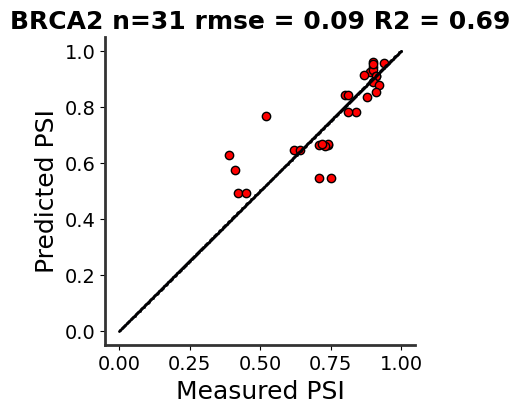

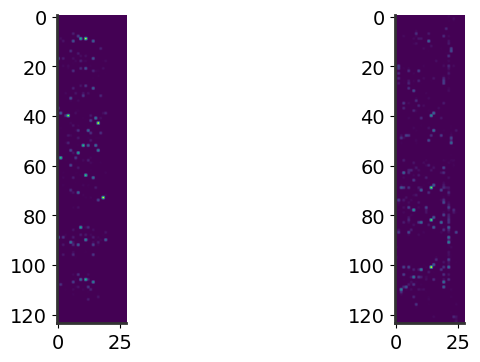

Analyzing gene CFTR...
Optimization terminated successfully.
         Current function value: 0.044888
         Iterations: 29
         Function evaluations: 59
Best basal shift: 4.2


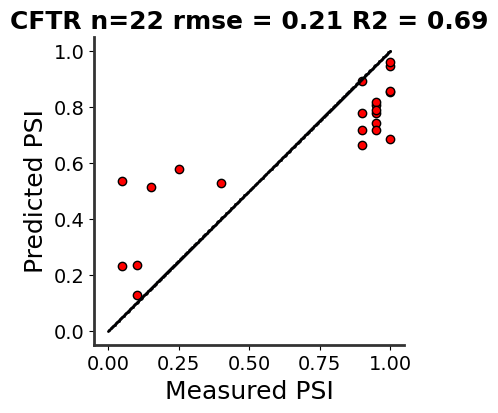

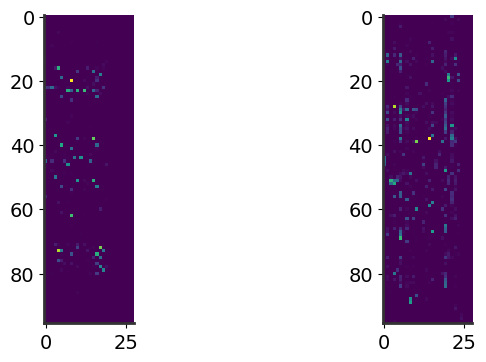

Analyzing gene FAS...
Optimization terminated successfully.
         Current function value: 0.019472
         Iterations: 28
         Function evaluations: 56
Best basal shift: 3.5


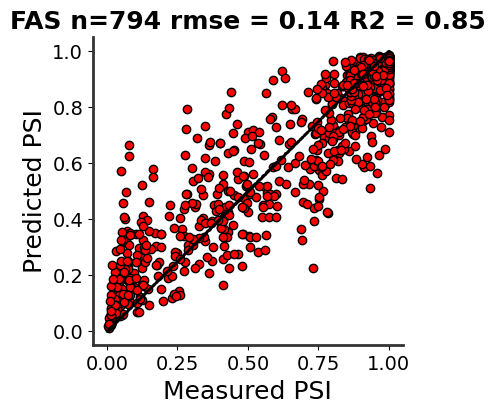

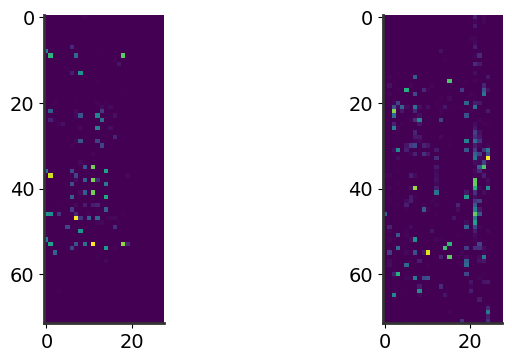

Analyzing gene SMN1...
Optimization terminated successfully.
         Current function value: 0.043461
         Iterations: 17
         Function evaluations: 34
Best basal shift: -0.1


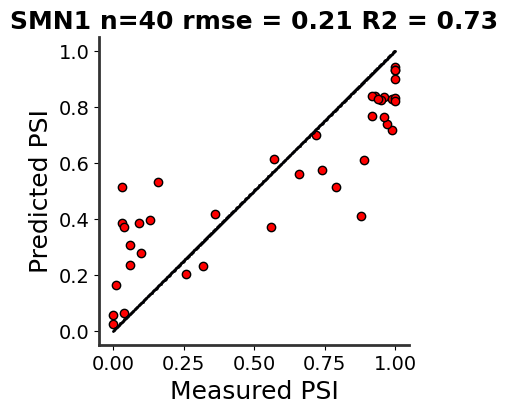

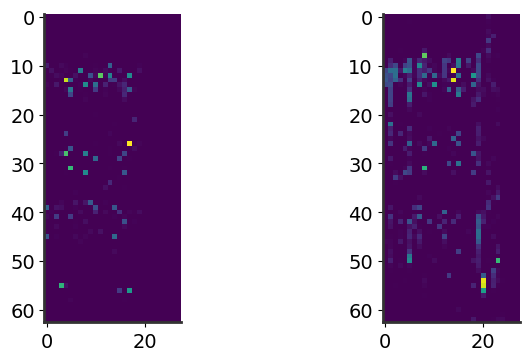

Analyzing gene SMN2...
Optimization terminated successfully.
         Current function value: 0.064903
         Iterations: 21
         Function evaluations: 42
Best basal shift: -0.2


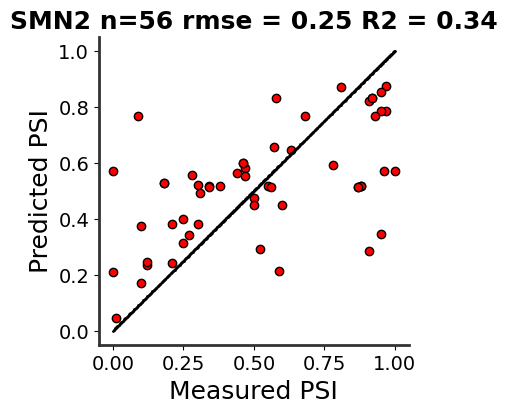

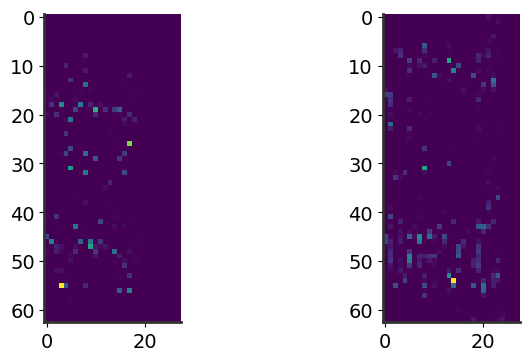

Analyzing gene WT1...
Optimization terminated successfully.
         Current function value: 0.026410
         Iterations: 30
         Function evaluations: 60
Best basal shift: -5.9


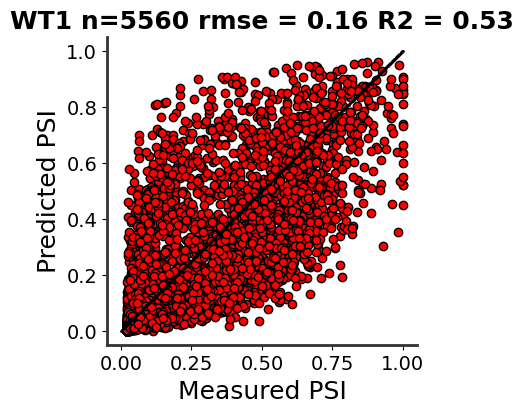

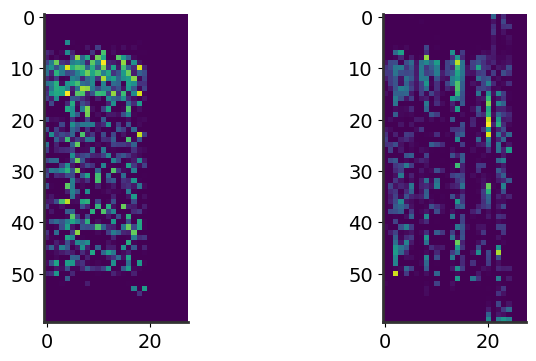

In [14]:
best_models = {}

for gene in sorted(set(all_assay_df.gene)):
    print(f"Analyzing gene {gene}...")

    df = all_assay_df[all_assay_df.gene == gene].copy()
    flanked_exon_length = len(df.iloc[0].flanked_sequence)

    input_to_model = utils.create_input_data(list(df.flanked_sequence))[:-1] # -1 to ignore structure string

    def get_rmse(basal_shift):
        custom_model = generate_custom_model.generate_custom_model(flanked_exon_length, basal_shift)
        predictions = custom_model(input_to_model).numpy().flatten()
        return ((df.PSI-predictions)**2).mean()
    
    best_basal_shift = optimize.fmin(get_rmse, 0)[0]  # find best basal shift
    best_model = generate_custom_model.generate_custom_model(flanked_exon_length, best_basal_shift)
    
    best_models[gene] = best_model # store the best model for later
    
    print(f"Best basal shift: {best_basal_shift:.1f}")

    df["predictions"] = best_model(input_to_model).numpy().flatten()
    if (type(model_predictions_df) == type(None)):
        model_predictions_df = df["predictions"]
    else:
        model_predictions_df = pd.concat([ model_predictions_df, df["predictions"] ])
        
    x = df.PSI
    y = df.predictions
    
    rmse = np.sqrt(((x-y)**2).mean())
    R2 = 1 - ((x-y)**2).mean() / x.var(ddof=0)

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    ax.scatter(x,y, c='r')
    ax.set_xlabel("Measured PSI")
    ax.set_ylabel("Predicted PSI")

    grid = np.linspace(0,1,500)
    ax.scatter(grid, grid, s=1, c='b')

    ax.set_title(f"{gene} n={len(x)} rmse = {rmse:.2f} R2 = {R2:.2f}")

    plt.show()
    
    activations_model = Model(
        inputs=best_model.inputs, 
        outputs=[best_model.get_layer("activity_regularization_2").output,
                 best_model.get_layer("activity_regularization_3").output]
        )

    fig,ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].imshow(np.abs(activations_model(input_to_model)[0]).max(axis=0))
    ax[1].imshow(np.abs(activations_model(input_to_model)[1]).max(axis=0))
    plt.show()
    
all_assay_df["predictions"] = model_predictions_df

# Nice plots for publication

0 WT1 WT1 exon 5
2962    TTTCTAGAGTTAGGGATGGGAGCTCCAGCACAGTGAAATGGACAGAAGGCTAGAGCAAGTGAGTG
5472    TTTCTAGAGTTACCACCGGGAGCTCCAACACAGTGAAATGGACAGAAGGGCAGAGCAAGTGAGTG
897     TTTCTAGAGTTGCTGCCGGGAGCTCCAGCACAGTGAAATGGACAGAAGGGCAGAGCAAGTGAGTG
3831    TTTCTAGAGTTCTTCTCGGGAGCTCCAGCGAAGTGAAATGGACAGAAGGGCAGAGCAAGTGAGTG
5173    TTTCTAGAGTTCGCGCCGGGAGCTCCAGCACAGTGAAATGGACAGAAGCGCAGAGCAAGTGAGTG
Name: flanked_sequence, dtype: object
1/1 [==============================] - 0s 99ms/step
1 FAS FAS exon 6
105    CCTACAGGATCCAGATCTAACTTGCTGTGGTTTTGTCTTCTTCTTTTCCCGATTCTAGTAATTGTTTGGGGTAAGTT
674    CCTACAGGATCCAGATCTAACTTGTTGTGGCTTTGTCTTCTTCTTTTCCCAATTCCAGTAATTGTTTGGGGTAAGTT
604    CCTACAGGATCCAGATCTAACTTGTGGTGGTTTTGTCTTCTTCTTCTCCCGATTCTAGTAATTGTTTGGGGTAAGTT
699    CCTACAGGATCCAGATCTAACTTGTTGTGGTTGTGTCTCCTTCTTTTGCCAATTCCAGTAATTGTTTGGGGTAAGTT
714    CCTACAGGATCCAGATCTAACTTGTTGTGGTTGTGTCTTCTGCTTTTGCCGATTCTACTAATTGTTTGGGGTAAGTT
Name: flanked_sequence, dtype: object
1/1 [==============================] - 0s 9

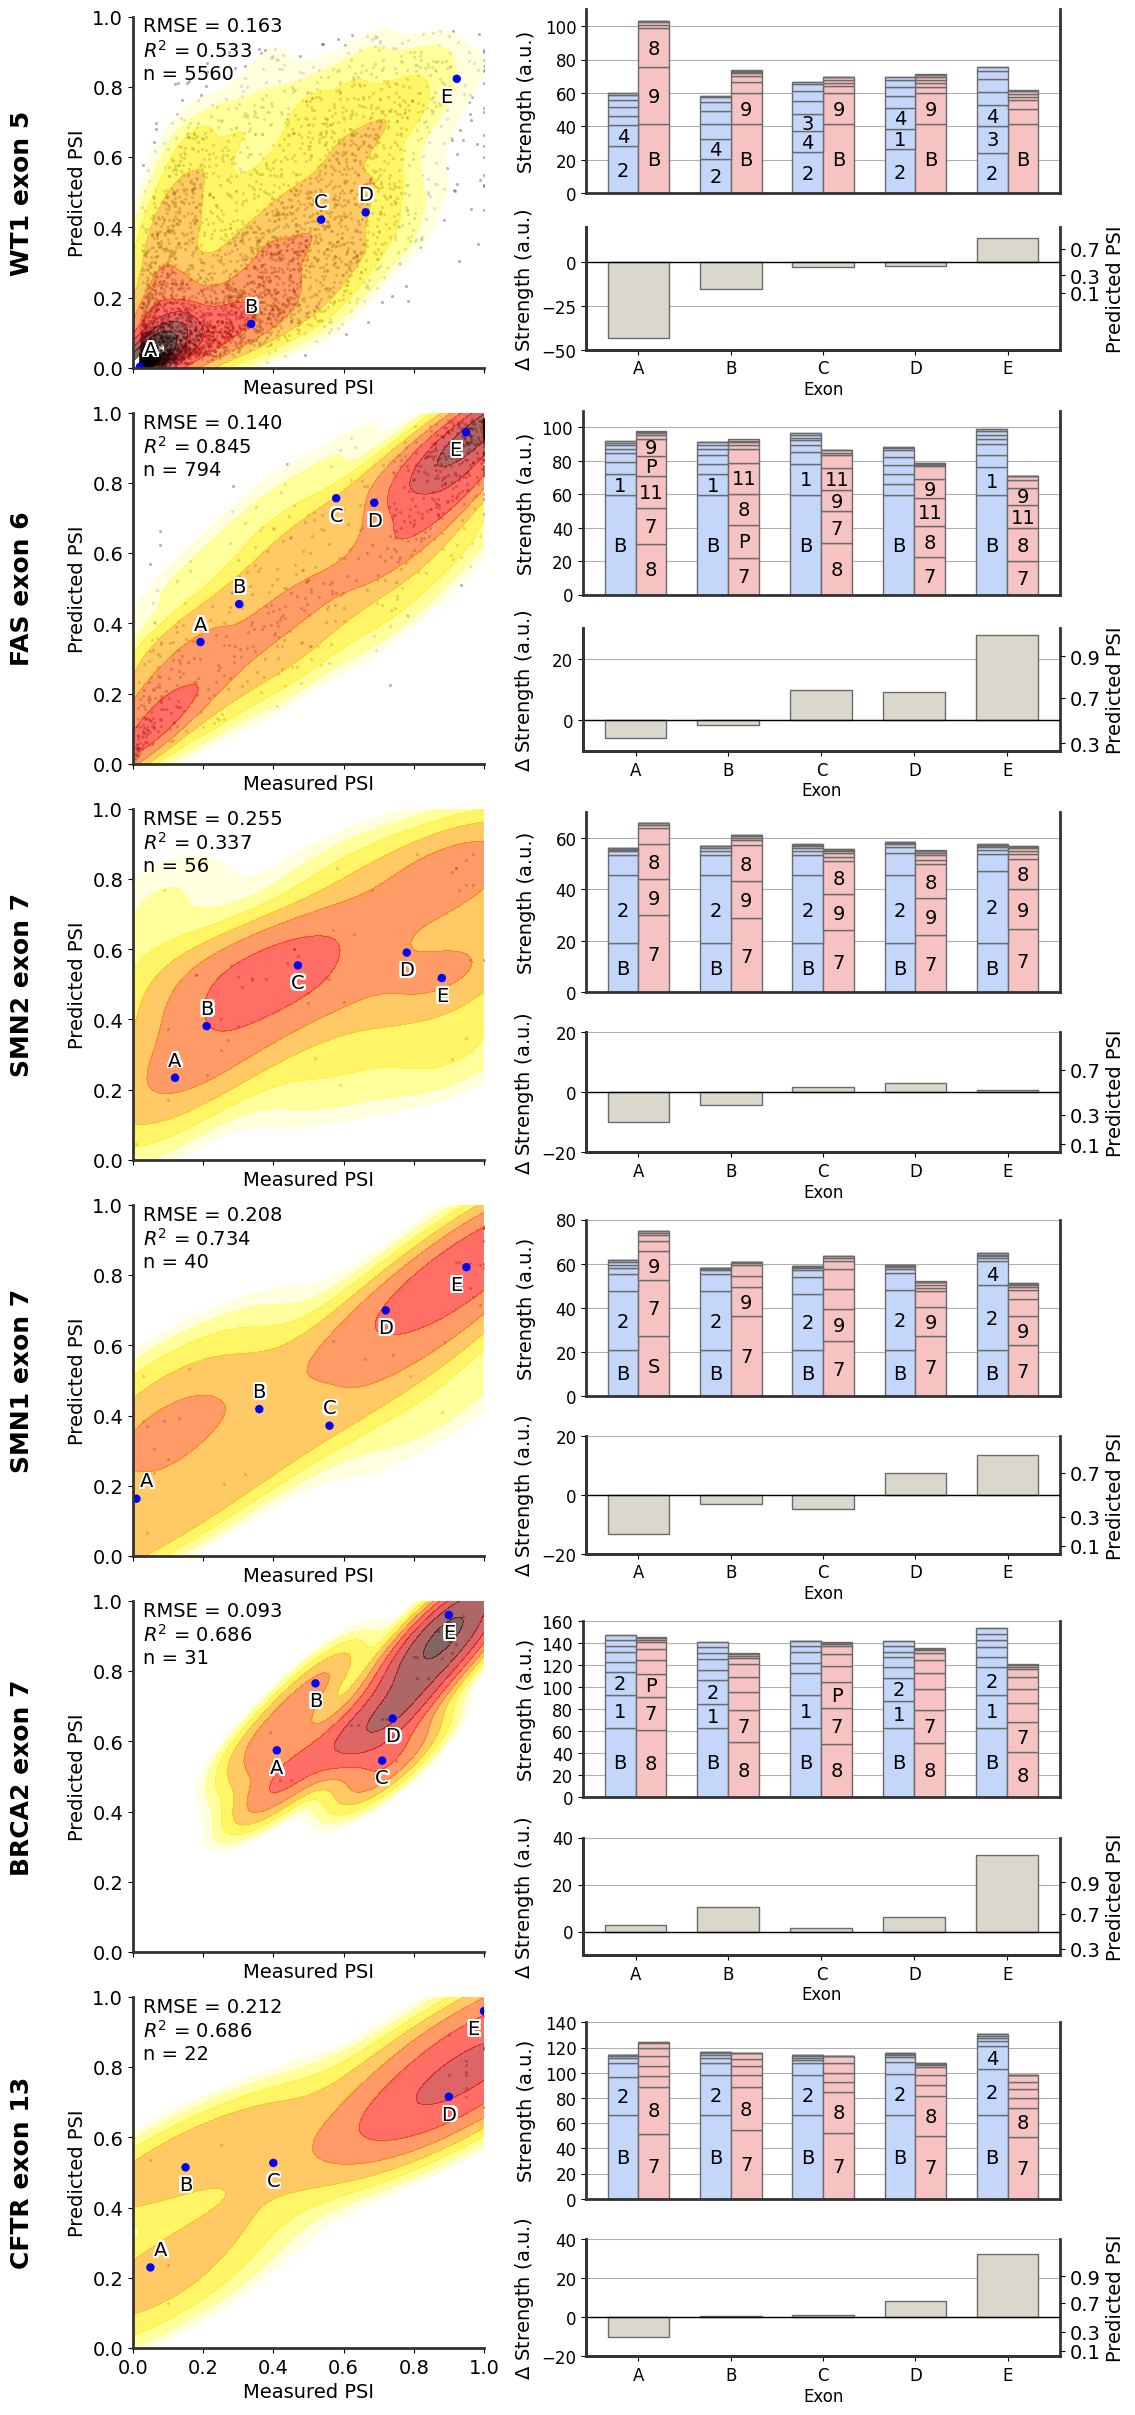

In [38]:
import figutils
from scipy.stats import gaussian_kde

genes_to_plot = ["WT1", "FAS", "SMN2", "SMN1", "BRCA2", "CFTR"]
gene_names = ["WT1 exon 5", "FAS exon 6", "SMN2 exon 7", "SMN1 exon 7", "BRCA2 exon 7", "CFTR exon 13"]
force_y_ranges = [(0,110),(0,110),(0,70),(0,80),(0,160),(0,140)]
delta_force_y_ranges = [(-50,20),(-10,30),(-20,20),(-20,20),(-10,40),(-20,40)]
numbers_min_bar_heights = [10,10,10,10,20,15]

n_plots = len(genes_to_plot)

fig = plt.figure(layout='constrained', figsize=(8.8*5/4, 4*n_plots))
subfigs = fig.subfigures(1, 2, hspace=0.1, width_ratios=(2.3,3))

#subfigs[0].suptitle("A", x=0, fontsize=20)
#subfigs[1].suptitle("B", x=0, fontsize=20)

force_plot_subfigs = subfigs[1].subfigures(n_plots,1)

axarr = subfigs[0].subplots(n_plots, 1, sharex=True, sharey=False)
axarr = axarr.flatten()

for i,(gene, gene_name,parent_figure,force_y_range, delta_force_y_range,numbers_min_bar_height) in enumerate(zip(genes_to_plot, gene_names, force_plot_subfigs, force_y_ranges, delta_force_y_ranges,numbers_min_bar_heights,strict=True)):
    print(i,gene,gene_name)   
    
    df = all_assay_df[all_assay_df.gene == gene].copy()

    m_psi = np.array(df.PSI)
    p_psi = np.array(df.predictions)
    
    # record RMSE
    rmse = np.sqrt(((m_psi - p_psi) ** 2).mean())
    rsquared = 1 - ((m_psi-p_psi)**2).mean() / m_psi.var(ddof=0)
    
    axarr[i].scatter(m_psi, p_psi, alpha=0.3, s=5, linewidth=0., c='k') # cmap=plt.cm.hot_r, 
    
    xy = np.vstack([m_psi, p_psi])
    kde = gaussian_kde(xy)
    z = kde(xy)    
    grid_resolution = 100
    A, B = np.meshgrid(np.linspace(0, 1, grid_resolution), np.linspace(0, 1, grid_resolution))
    xygrid = np.vstack([A.flatten(), B.flatten()])
    zgrid = kde(xygrid)
    axarr[i].contourf(A, B,
                np.log(zgrid).reshape(*A.shape), 10000, origin='lower',
                cmap=plt.cm.hot_r, alpha=0.6, levels=np.linspace(-2, 3, 10))


    # choose a subset of exons to highlight:
    if (gene == "CFTR"): # CFTR has so few exons we need to pick manually
        highlighted_df = df.sort_values(by="PSI", axis="rows").iloc[ [0,4,6,7,-1] ]
    else:
        # Group the exons by their PSI and then randomly select one to highlight from each group
        df["PSI_bin"] = np.floor(4.99*(df.PSI - np.min(df.PSI))/(np.max(df.PSI)-np.min(df.PSI)))
        highlighted_df = df.groupby("PSI_bin").sample(n=1, random_state=(2018 if gene == "SMN1" else 2022)).sort_values(by="PSI", axis="rows") # use a different seed for SMN1 in order to highlight stem loop filters
    
    
    pd.options.display.max_colwidth = 140
    print(highlighted_df.flanked_sequence)
    
    def write_text_with_white_background(ax, text, x, y):
        """ create a white glow around the text for readability 
        """
        for k in np.linspace(-1,1,8): 
            for j in np.linspace(-1,1,8):
                ax.annotate(text, xy=(x+k*0.005,y+j*0.005), color='white', ha='center', va='center')
        ax.annotate(text, xy=(x,y), ha='center', va='center')
    
    for exon_name, row in zip(['A','B','C','D','E'],highlighted_df.iterrows()):
        #axarr[i].scatter(row[1].x, row[1].y, alpha=1, s=60, linewidth=2., c='b', edgecolors='k')
        axarr[i].add_patch(plt.Circle((row[1].PSI, row[1].predictions), 0.01, color='b', clip_on=True))   
        #axarr[i].add_patch(plt.text(row[1].x, row[1].y, str(row[0])))  
        text_pos_x = row[1].PSI+(0.03 if row[1].PSI < 0.1 else (-0.03 if row[1].PSI > 0.9 else 0))
        text_pos_y = (row[1].predictions-0.05 if row[1].predictions > 0.5 else row[1].predictions + 0.05)
        write_text_with_white_background(axarr[i], exon_name, text_pos_x,text_pos_y)
    
    
    axarr[i].text(-0.35,1/2, gene_name, rotation='vertical', va='center', fontsize=18, fontweight="bold")
    
    #if i in [0, 3]:
    axarr[i].set_ylabel(f"Predicted PSI", fontsize=14)
    #if i == n_plots-1:
    axarr[i].set_xlabel(f"Measured PSI", fontsize=14)
    
    axarr[i].set_ylim(0,1)
        
    axarr[i].text(3e-2, 1., f'RMSE = {rmse:.3f}\n$R^2$ = {rsquared:.3f}\nn = {m_psi.shape[0]}', ha='left', fontsize=14, va='top')

    force_plot.draw_force_plot(list(highlighted_df.flanked_sequence),
             ["A","B","C\nExon","D","E"],
             draw_numbers=True, 
             numbers_min_bar_height=numbers_min_bar_height,
             ys=[0.1, 0.3, 0.7, 0.9, 0.975], height_ratios=[3, 2], delta_bar_width=2,
             vertical=True, sharex=True,
             vertical_adjustement=0.5,
             parent_figure=parent_figure,
             custom_model=best_models[gene],
             force_y_range=force_y_range, delta_force_y_range=delta_force_y_range,
            )
    
    
for ax in axarr:
    if not isinstance(ax, float):
        ax.set_xlim(0,1)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set(adjustable='box', aspect='equal')

        
fig.savefig('./figs/other_datasets.svg', bbox_inches='tight')
fig.savefig('./figs/other_datasets.png', bbox_inches='tight', dpi=300)

# Similar plot with just the scatter plots

0 WT1 WT1 exon 5
2962    TTTCTAGAGTTAGGGATGGGAGCTCCAGCACAGTGAAATGGACAGAAGGCTAGAGCAAGTGAGTG
5472    TTTCTAGAGTTACCACCGGGAGCTCCAACACAGTGAAATGGACAGAAGGGCAGAGCAAGTGAGTG
897     TTTCTAGAGTTGCTGCCGGGAGCTCCAGCACAGTGAAATGGACAGAAGGGCAGAGCAAGTGAGTG
3831    TTTCTAGAGTTCTTCTCGGGAGCTCCAGCGAAGTGAAATGGACAGAAGGGCAGAGCAAGTGAGTG
5173    TTTCTAGAGTTCGCGCCGGGAGCTCCAGCACAGTGAAATGGACAGAAGCGCAGAGCAAGTGAGTG
Name: flanked_sequence, dtype: object
1 FAS FAS exon 6
105    CCTACAGGATCCAGATCTAACTTGCTGTGGTTTTGTCTTCTTCTTTTCCCGATTCTAGTAATTGTTTGGGGTAAGTT
674    CCTACAGGATCCAGATCTAACTTGTTGTGGCTTTGTCTTCTTCTTTTCCCAATTCCAGTAATTGTTTGGGGTAAGTT
604    CCTACAGGATCCAGATCTAACTTGTGGTGGTTTTGTCTTCTTCTTCTCCCGATTCTAGTAATTGTTTGGGGTAAGTT
699    CCTACAGGATCCAGATCTAACTTGTTGTGGTTGTGTCTCCTTCTTTTGCCAATTCCAGTAATTGTTTGGGGTAAGTT
714    CCTACAGGATCCAGATCTAACTTGTTGTGGTTGTGTCTTCTGCTTTTGCCGATTCTACTAATTGTTTGGGGTAAGTT
Name: flanked_sequence, dtype: object
2 SMN2 SMN2 exon 7
6420    CTTACAGGGTTTTAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTTCTTAAATTAAGGAGTAAGTC

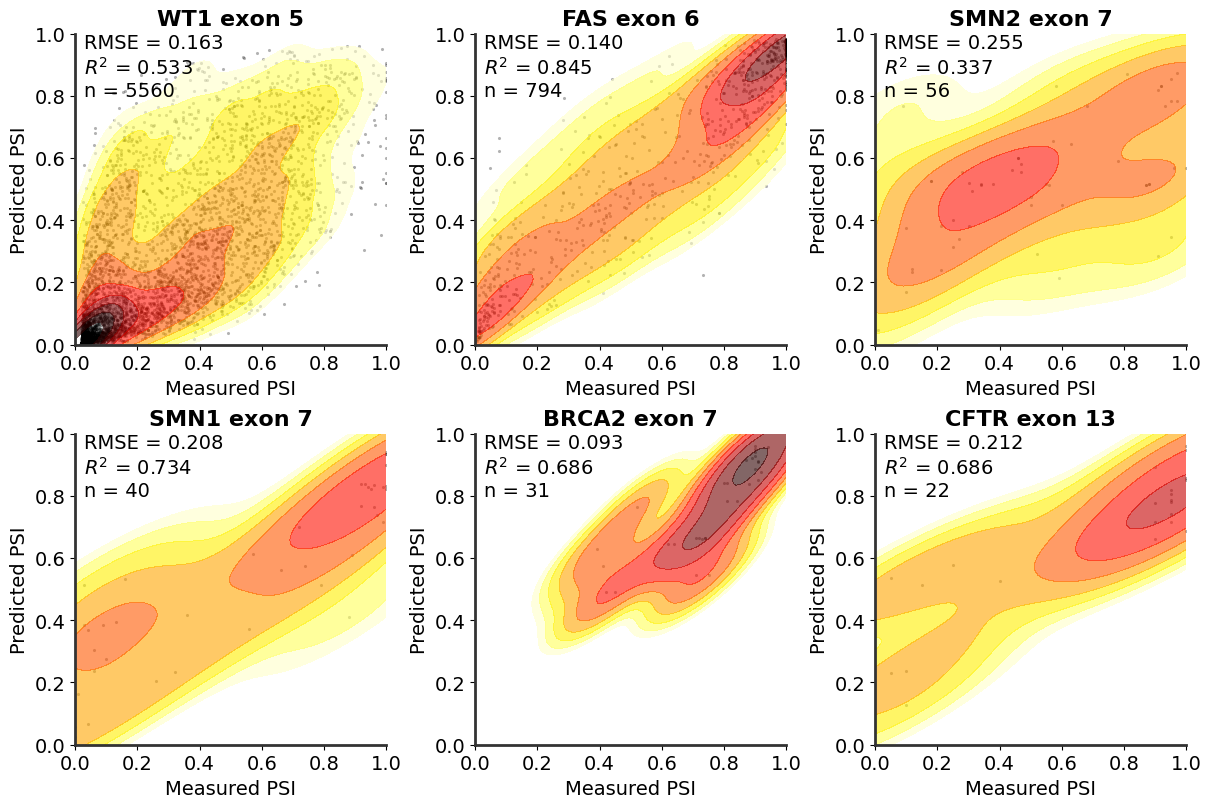

In [23]:
import figutils
from scipy.stats import gaussian_kde

n_plots = len(genes_to_plot)

fig = plt.figure(layout='constrained', figsize=(12, 8))

axarr = fig.subplots(2, 3, sharex=False, sharey=False)
axarr = axarr.flatten()

for i,(gene, gene_name,force_y_range, delta_force_y_range,numbers_min_bar_height) in enumerate(zip(genes_to_plot, gene_names, force_y_ranges, delta_force_y_ranges,numbers_min_bar_heights,strict=True)):
    print(i,gene,gene_name)   
    
    df = all_assay_df[all_assay_df.gene == gene].copy()

    m_psi = np.array(df.PSI)
    p_psi = np.array(df.predictions)
    
    # record RMSE
    rmse = np.sqrt(((m_psi - p_psi) ** 2).mean())
    rsquared = 1 - ((m_psi-p_psi)**2).mean() / m_psi.var(ddof=0)
    
    axarr[i].scatter(m_psi, p_psi, alpha=0.3, s=5, linewidth=0., c='k') # cmap=plt.cm.hot_r, 
    
    xy = np.vstack([m_psi, p_psi])
    kde = gaussian_kde(xy)
    z = kde(xy)    
    grid_resolution = 100
    A, B = np.meshgrid(np.linspace(0, 1, grid_resolution), np.linspace(0, 1, grid_resolution))
    xygrid = np.vstack([A.flatten(), B.flatten()])
    zgrid = kde(xygrid)
    axarr[i].contourf(A, B,
                np.log(zgrid).reshape(*A.shape), 10000, origin='lower',
                cmap=plt.cm.hot_r, alpha=0.6, levels=np.linspace(-2, 3, 10))


    # choose a subset of exons to highlight:
    if (gene == "CFTR"): # CFTR has so few exons we need to pick manually
        highlighted_df = df.sort_values(by="PSI", axis="rows").iloc[ [0,4,6,7,-1] ]
    else:
        # Group the exons by their PSI and then randomly select one to highlight from each group
        df["PSI_bin"] = np.floor(4.99*(df.PSI - np.min(df.PSI))/(np.max(df.PSI)-np.min(df.PSI)))
        highlighted_df = df.groupby("PSI_bin").sample(n=1, random_state=2022).sort_values(by="PSI", axis="rows")
    
    
    pd.options.display.max_colwidth = 140
    print(highlighted_df.flanked_sequence)
        
    #axarr[i].text(-0.35,1/2, gene_name, rotation='vertical', va='center', fontsize=18, fontweight="bold")
    axarr[i].set_title(gene_name, fontsize=16)
    
    #if i in [0, 3]:
    axarr[i].set_ylabel(f"Predicted PSI", fontsize=14)
    #if i == n_plots-1:
    axarr[i].set_xlabel(f"Measured PSI", fontsize=14)
    
    axarr[i].set_ylim(0,1)
        
    axarr[i].text(3e-2, 1., f'RMSE = {rmse:.3f}\n$R^2$ = {rsquared:.3f}\nn = {m_psi.shape[0]}', ha='left', fontsize=14, va='top')
    # axarr[i].text(0.5, 0.5, f'{i}')
       
for ax in axarr:
    if not isinstance(ax, float):
        ax.set_xlim(0,1)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set(adjustable='box', aspect='equal')

        
fig.savefig('./figs/other_datasets_only_scatter.svg', bbox_inches='tight')
fig.savefig('./figs/other_datasets_only_scatter.png', bbox_inches='tight', dpi=300)

# Show all the basal strengths in one bar plot

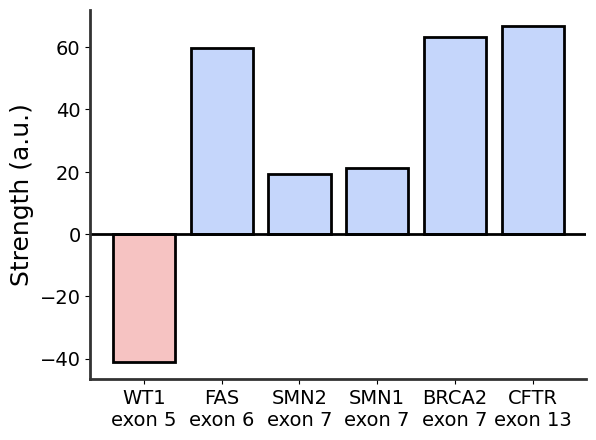

In [16]:
skipping_color="#F6C3C2"
inclusion_color="#C5D6FB"

two_line_gene_name = [x.replace(" ","\n",1) for x in gene_names]

basal_strengths = {x:-force_plot.get_model_midpoint(best_models[x]) for x in genes_to_plot}

plt.bar(range(len(genes_to_plot)), 
        [basal_strengths[x] for x in genes_to_plot], 
        tick_label = two_line_gene_name,
        color = [ inclusion_color if basal_strengths[x]>0 else skipping_color for x in genes_to_plot],
        edgecolor = 'k',
        linewidth=2
       )

plt.ylabel("Strength (a.u.)")

plt.axhline(0, color='k', linewidth=2)